In [1]:
import scanpy as sc

In [2]:
adata=sc.read("data/adata_raw.h5ad")

In [3]:
import pandas as pd
pd.DataFrame(adata.X.A,index=adata.obs_names,columns=adata.var_names).to_csv("data/counts.csv")

In [4]:
adata.var["ERCC"]=adata.var_names.str.startswith("ERCC")

In [5]:
sc.pp.calculate_qc_metrics(adata,qc_vars=["ERCC"], percent_top=None, log1p=False, inplace=True)

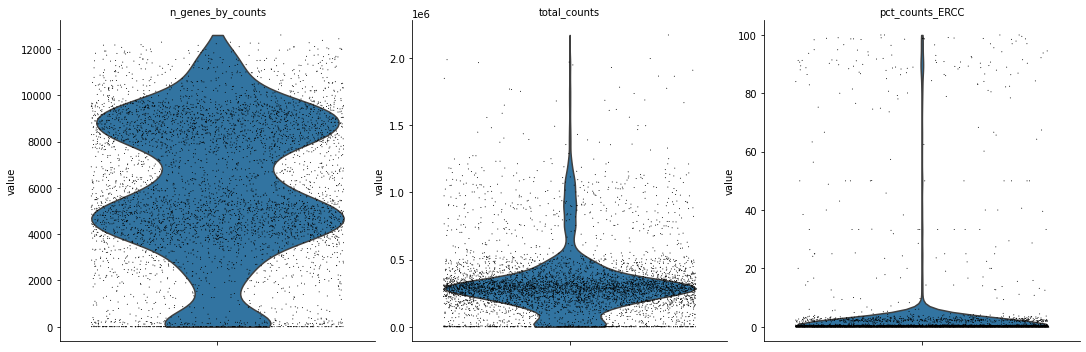

In [6]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts','pct_counts_ERCC'],
             jitter=0.4, multi_panel=True)
adata = adata[(adata.obs.n_genes_by_counts > 1000) & (adata.obs.pct_counts_ERCC < 5), :]

In [7]:
adata=adata[:,~adata.var.ERCC]

In [8]:
adata[adata.obs.devtime=="E16.5"].obs.plate.value_counts()

SS2_18_349    379
SS2_18_350    377
SS2_20_139    377
Name: plate, dtype: int64

In [9]:
def p_dev(dev):
    ldata=adata[adata.obs.devtime==dev].copy()
    ldata.var_names_make_unique()

    sc.pp.filter_genes(ldata,min_cells=3)
    sc.pp.normalize_total(ldata, target_sum=1e4)
    sc.pp.log1p(ldata)
    scf.pp.find_overdispersed(ldata)
    ldata.layers["scaled"]=sc.pp.scale(ldata.X,max_value=10,copy=True)
    ldata.obsm["X_pca"]=sc.pp.pca(ldata[:,ldata.var.highly_variable].layers["scaled"])
    sc.pp.neighbors(ldata,n_neighbors=30,n_pcs=30,metric="cosine")
    sc.tl.umap(ldata)
    sc.tl.leiden(ldata)
    return ldata

In [16]:
from scFates.tools.utils import ProgressParallel
from joblib import delayed

In [14]:
meta=pd.read_table("meta",header=None,index_col=0)

In [17]:
ldatas=ProgressParallel(total=len(meta[3].unique()),n_jobs=len(meta[3].unique()))(delayed(p_dev)(dev) for dev in meta[3].unique())

100%|██████████| 7/7 [00:37<00:00,  5.40s/it]


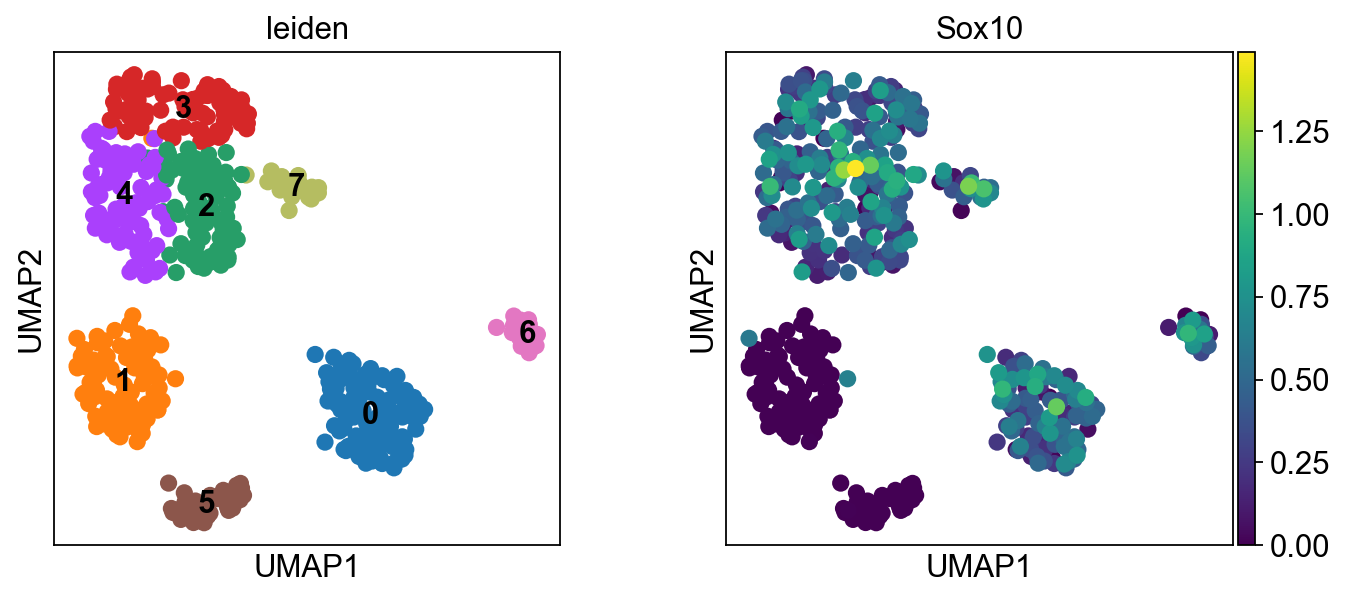

In [18]:
sc.set_figure_params()
sc.pl.umap(ldatas[1],color=["leiden","Sox10"],legend_loc="on data")

/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'glial_conta' as categorical


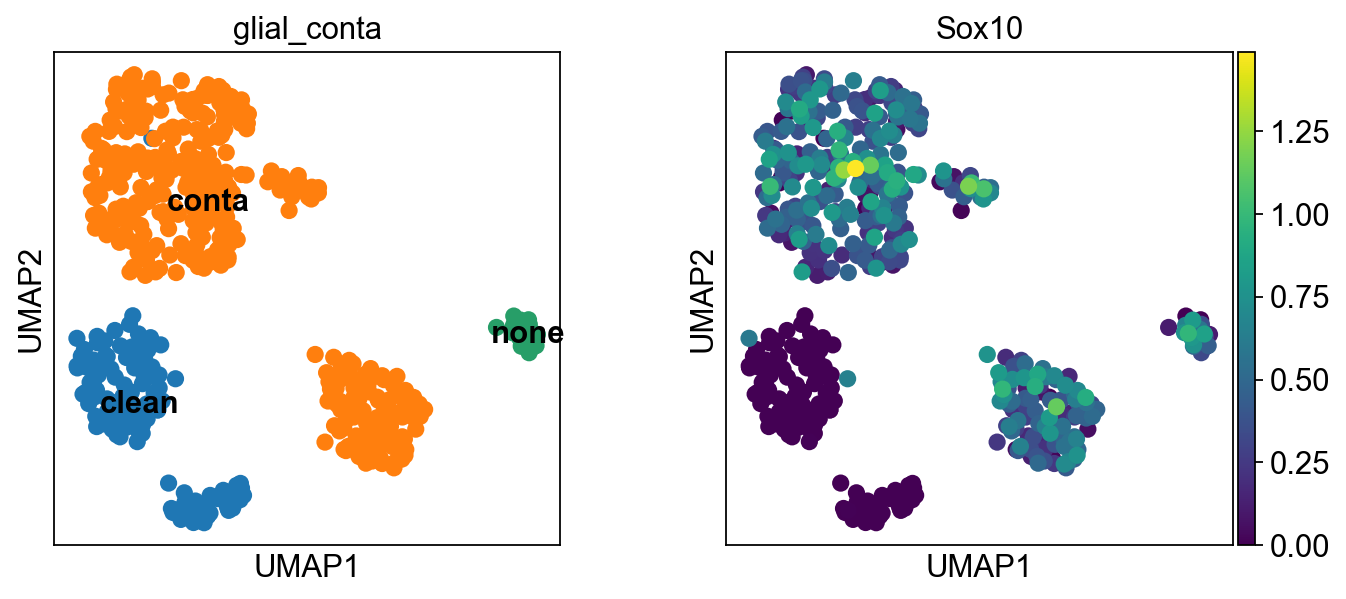

In [19]:
ldatas[1].obs["glial_conta"]="none"

ldatas[1].obs.loc[ldatas[1].obs["leiden"].isin(["1","5"]),"glial_conta"]="clean"
ldatas[1].obs.loc[ldatas[1].obs["leiden"].isin(["0","2","3","4","7"]),"glial_conta"]="conta"

sc.pl.umap(ldatas[1],color=["glial_conta","Sox10"],legend_loc="on data")

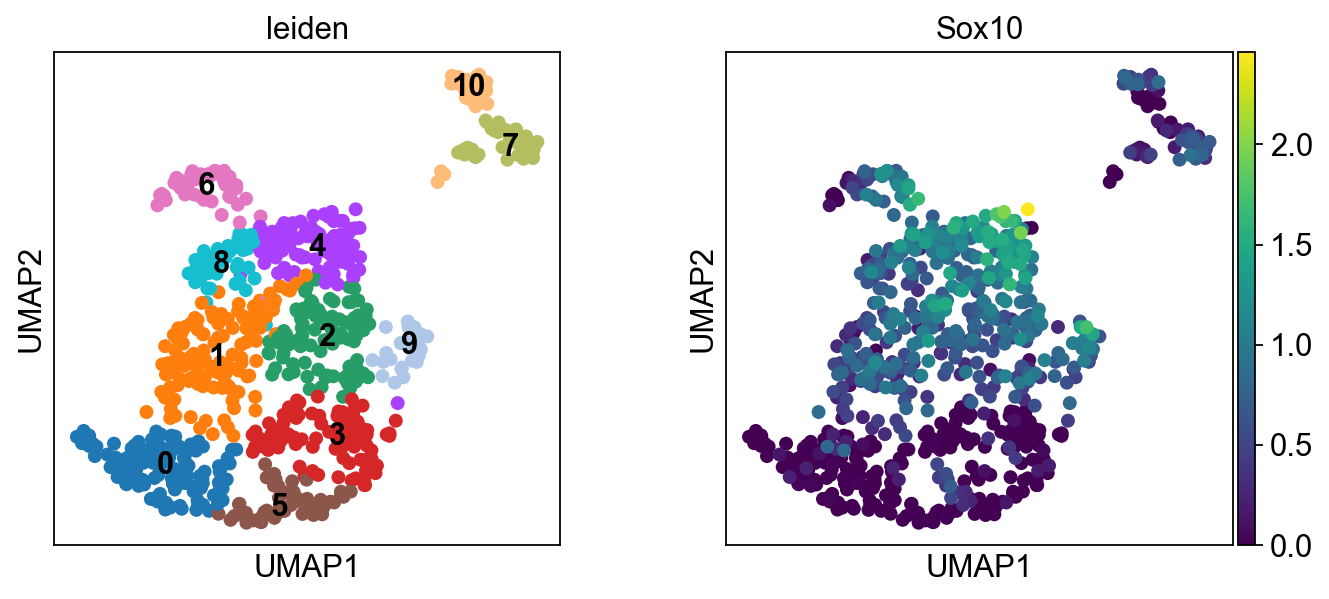

In [20]:
sc.set_figure_params()
sc.pl.umap(ldatas[3],color=["leiden","Sox10"],legend_loc="on data")

/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'glial_conta' as categorical


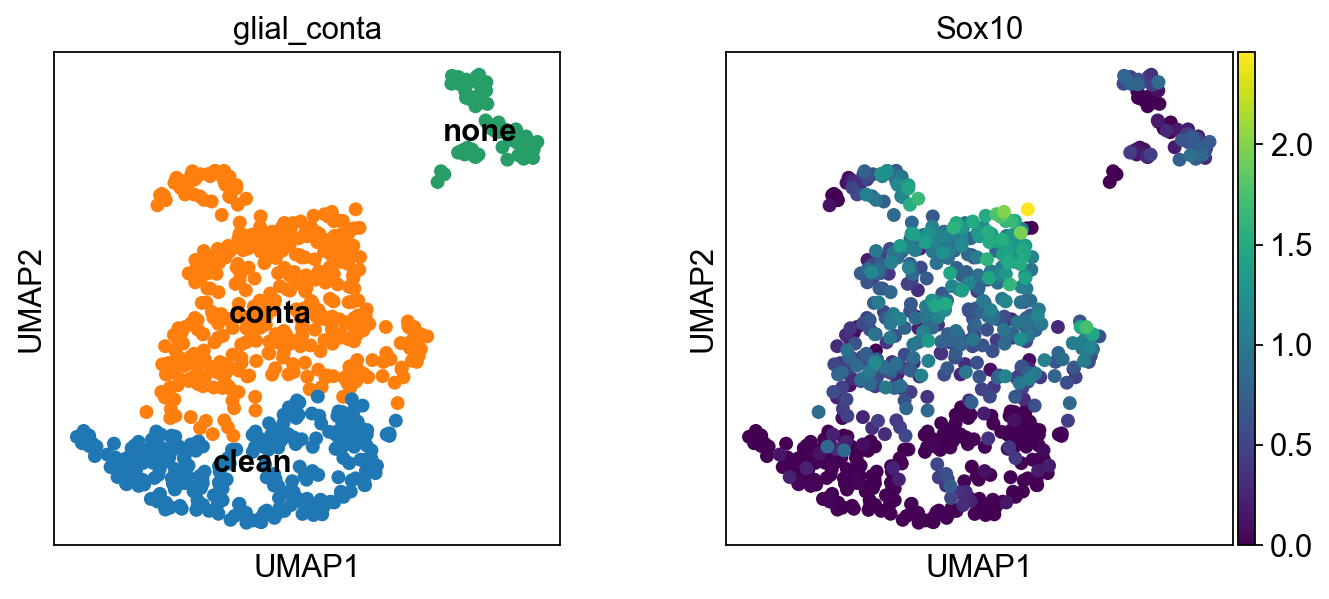

In [21]:
ldatas[3].obs["glial_conta"]="none"

ldatas[3].obs.loc[ldatas[3].obs["leiden"].isin(["0","3","5"]),"glial_conta"]="clean"
ldatas[3].obs.loc[ldatas[3].obs["leiden"].isin(["1","4","2","9","6","8"]),"glial_conta"]="conta"

sc.pl.umap(ldatas[3],color=["glial_conta","Sox10"],legend_loc="on data")

In [23]:
ldatas[3].obs.glial_conta.value_counts()

conta    420
clean    271
none      71
Name: glial_conta, dtype: int64

In [29]:
sc.pl.umap(ldatas[7],color=["leiden","Sox10"],legend_loc="on data")

IndexError: list index out of range

In [24]:
ldatas[1].obs.glial_conta.value_counts()

conta    358
clean    122
none      21
Name: glial_conta, dtype: int64

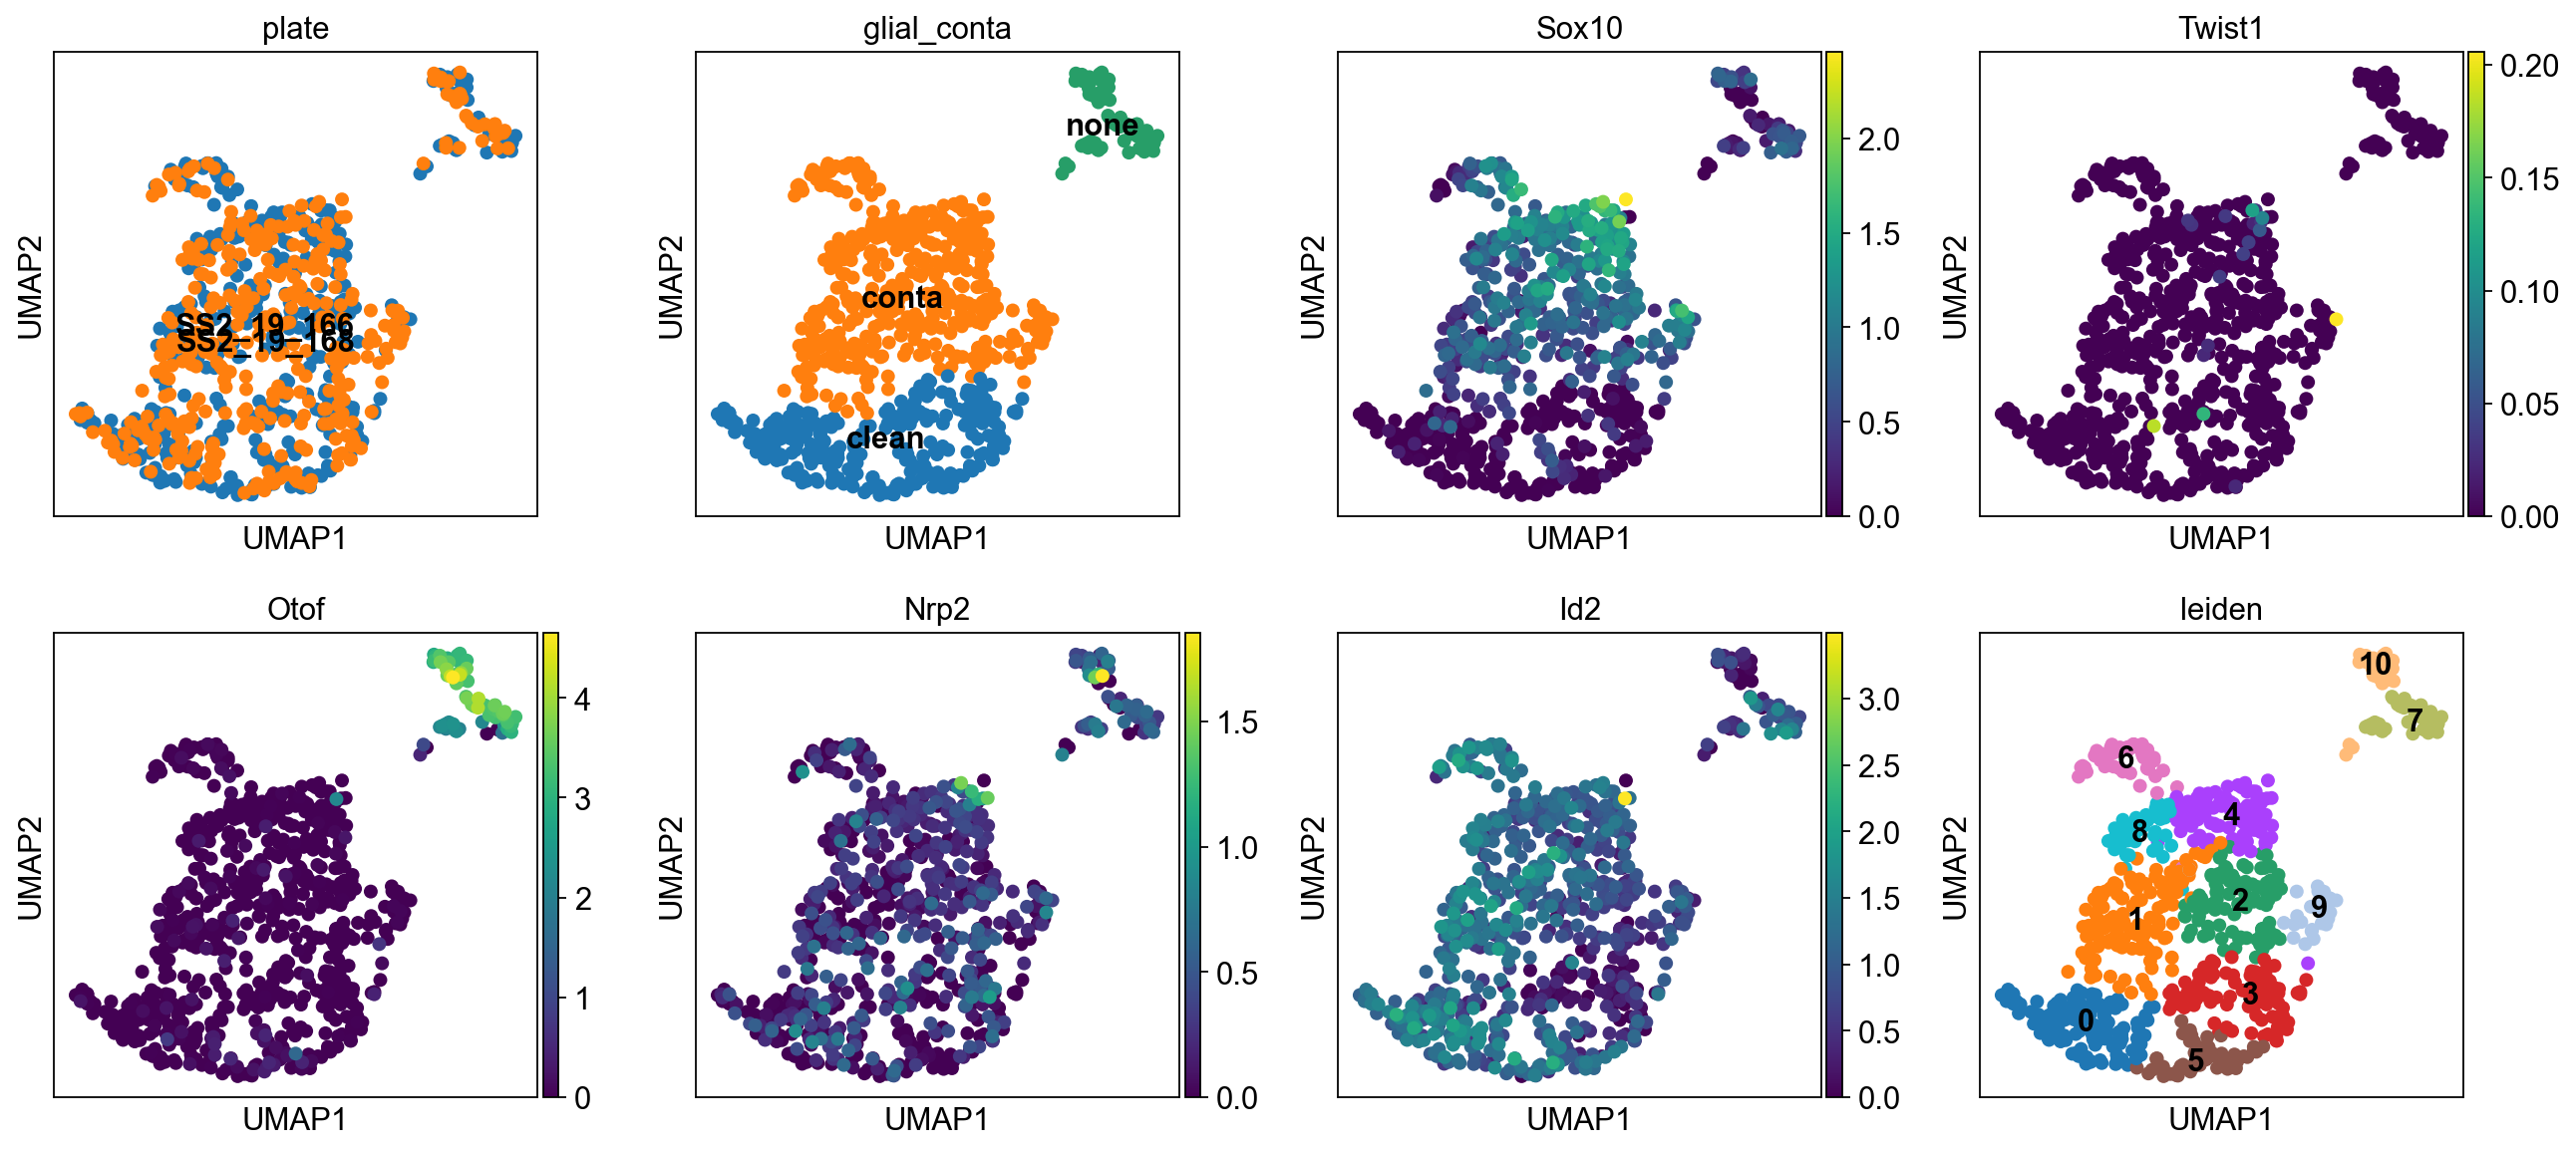

In [22]:
sc.pl.umap(ldatas[3],color=["plate","glial_conta","Sox10","Twist1","Otof","Nrp2","Id2","leiden"],legend_loc="on data")

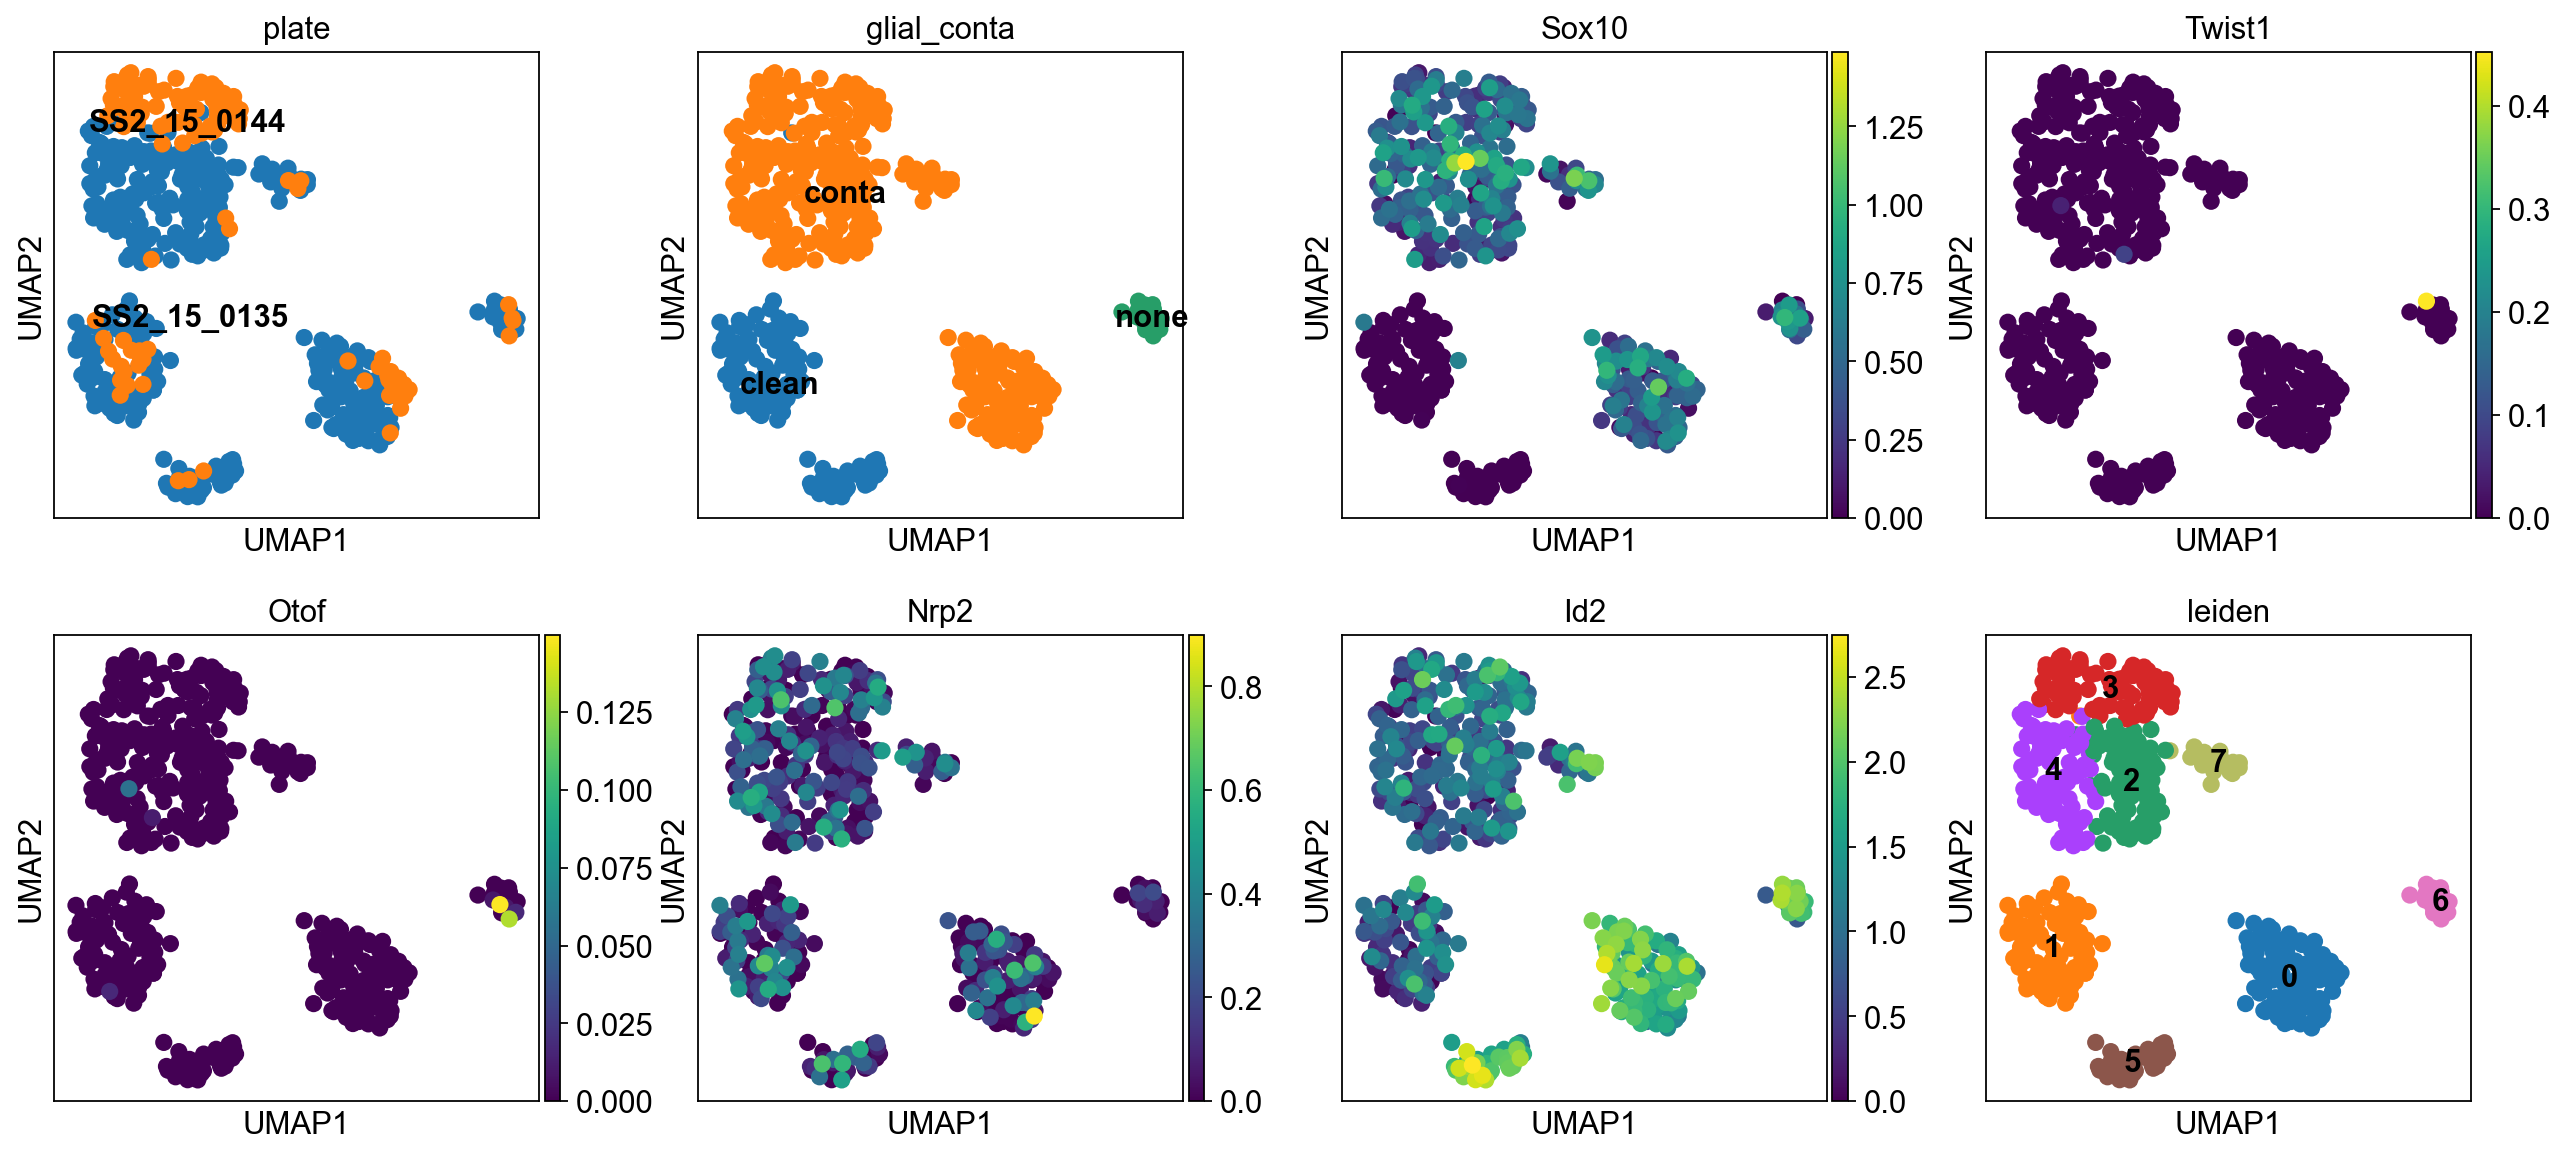

In [23]:
sc.pl.umap(ldatas[1],color=["plate","glial_conta","Sox10","Twist1","Otof","Nrp2","Id2","leiden"],legend_loc="on data")

In [24]:
from scFates.tools.utils import cor_mat_gpu
import cupy as cp
mat=cp.asarray(ldatas[3].X.A)
cormat=cor_mat_gpu(mat,mat)
cormat=cormat.get()

In [25]:
sox10=pd.DataFrame(cormat,index=ldatas[3].var_names,columns=ldatas[3].var_names).loc["Sox10"].sort_values(ascending=False)

(array([4.5000e+01, 5.1300e+02, 3.1200e+03, 1.0496e+04, 2.9990e+03,
        1.0940e+03, 5.0100e+02, 2.3000e+02, 1.1100e+02, 3.0000e+00]),
 array([-0.52946705, -0.3765202 , -0.22357333, -0.07062647,  0.08232039,
         0.23526725,  0.3882141 ,  0.54116094,  0.69410783,  0.8470547 ,
         1.0000015 ], dtype=float32),
 <BarContainer object of 10 artists>)

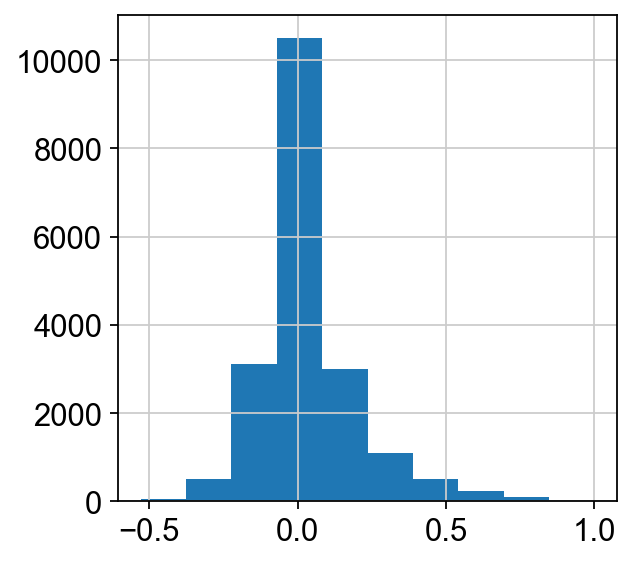

In [26]:
import matplotlib.pyplot as plt
plt.hist(sox10)

In [27]:
def run_clean(glial_code):
    scf.pp.find_overdispersed(ldatas[3])
    ldatas[3].var.loc[glial_code,"highly_variable"]=False
    ldatas[3].obsm["X_pca"]=sc.pp.pca(ldatas[3][:,ldatas[3].var.highly_variable].layers["scaled"])
    sc.pp.neighbors(ldatas[3],n_neighbors=30,n_pcs=30,metric="cosine")
    sc.tl.umap(ldatas[3])
    sc.tl.leiden(ldatas[3],key_added="leiden2")
    
    scf.pp.find_overdispersed(ldatas[1])
    ldatas[1].var.loc[ldatas[1].var_names[ldatas[1].var_names.isin(glial_code)],"highly_variable"]=False
    ldatas[1].obsm["X_pca"]=sc.pp.pca(ldatas[1][:,ldatas[1].var.highly_variable].layers["scaled"])
    sc.pp.neighbors(ldatas[1],n_neighbors=30,n_pcs=30,metric="cosine")
    sc.tl.umap(ldatas[1])
    sc.tl.leiden(ldatas[1])
    
    sc.pl.umap(ldatas[3],color=["glial_conta","Sox10","leiden2"],legend_loc="on data")
    sc.pl.umap(ldatas[1],color=["glial_conta","Sox10","leiden"],legend_loc="on data")

In [28]:
glial_code=sox10.index[(sox10>.3)]
len(glial_code)

1371

Finding overdispersed features
    computing mean and variances
    gam fitting
    found 3256 over-dispersed features (0:00:01) --> added 
    .var['res'], residuals of GAM fit.
    .var['lp'], p-value.
    .var['lpa'], BH adjusted p-value.
    .var['qv'], percentile of qui-squared distribution.
    .var['highly_variable'], feature is over-dispersed.

Finding overdispersed features
    computing mean and variances
    gam fitting
    found 2898 over-dispersed features (0:00:00) --> added 
    .var['res'], residuals of GAM fit.
    .var['lp'], p-value.
    .var['lpa'], BH adjusted p-value.
    .var['qv'], percentile of qui-squared distribution.
    .var['highly_variable'], feature is over-dispersed.



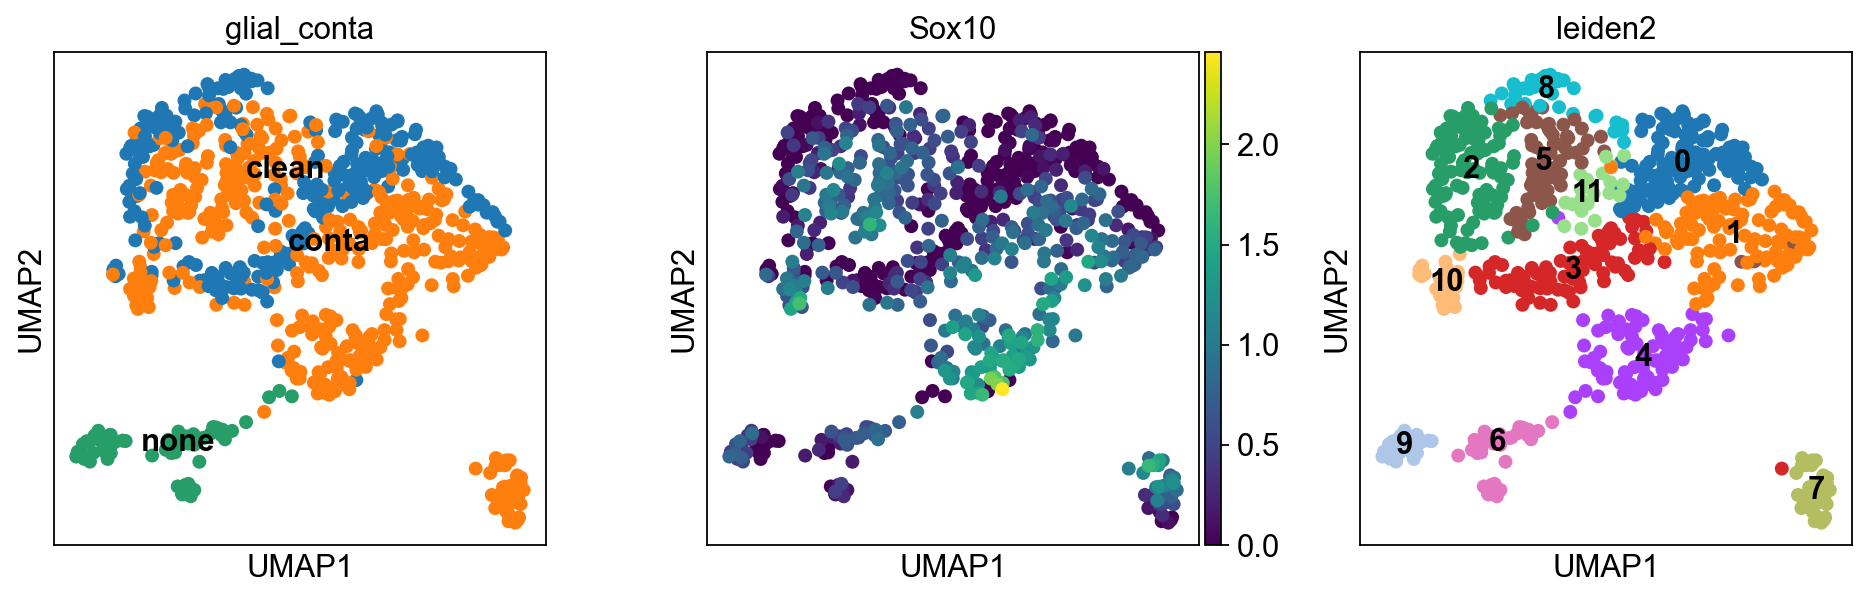

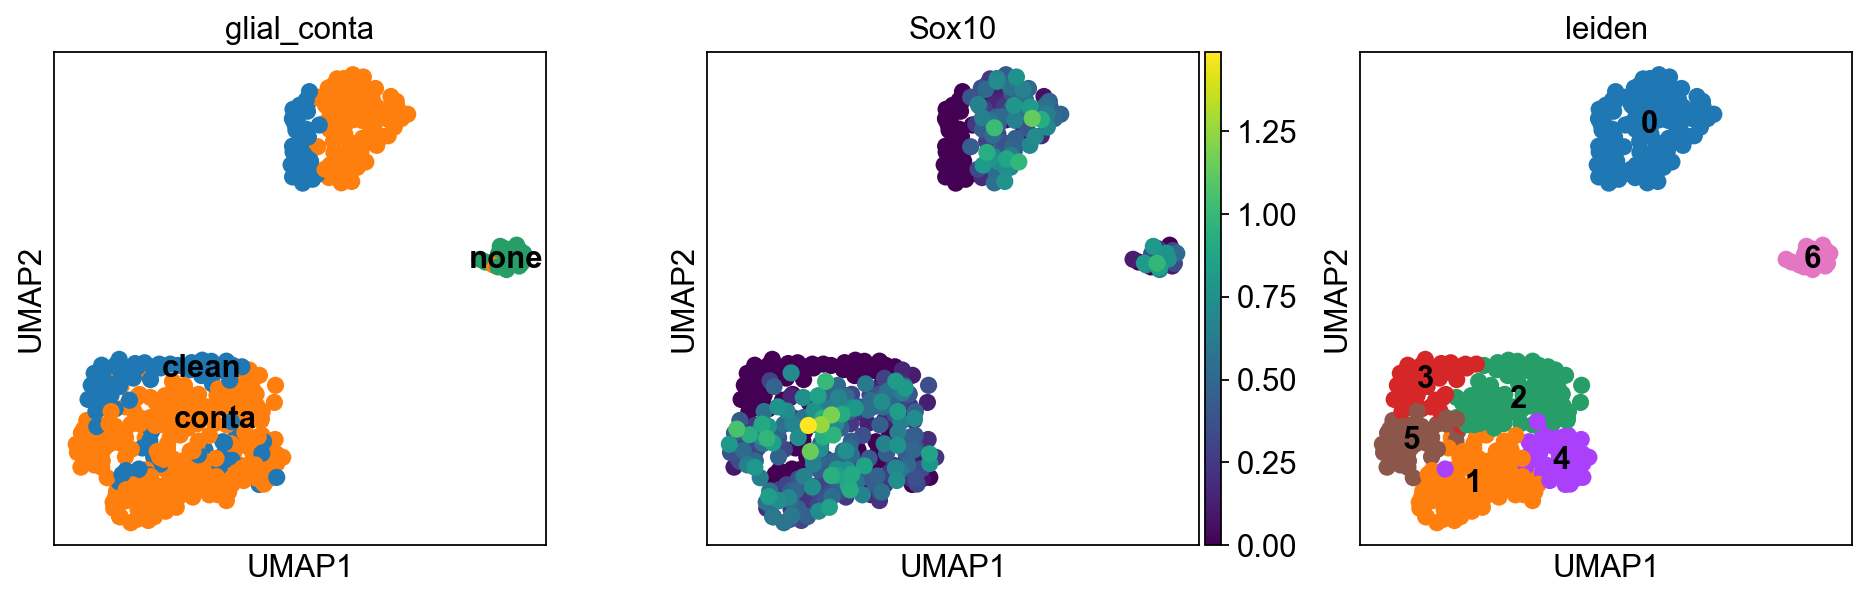

In [29]:
run_clean(glial_code)

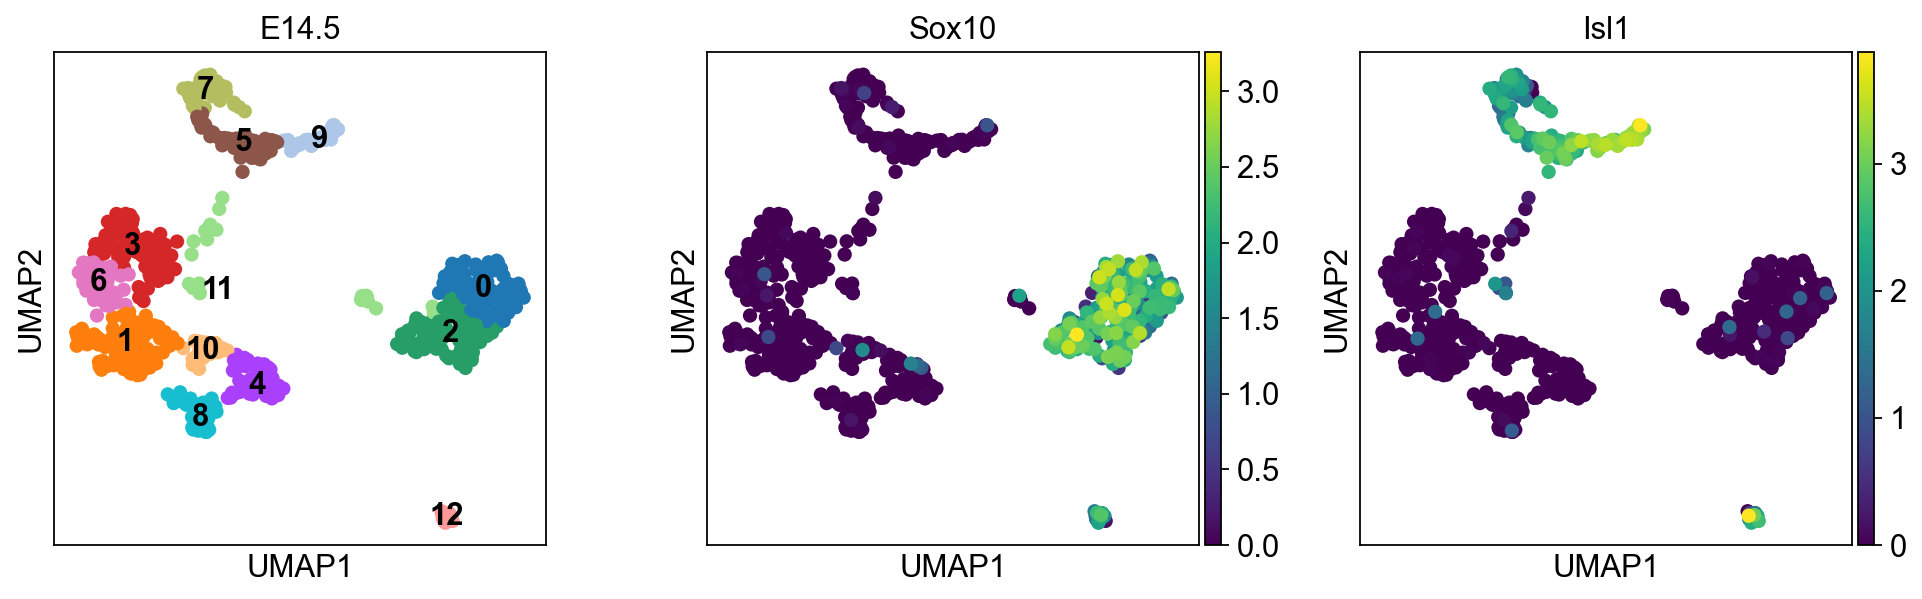

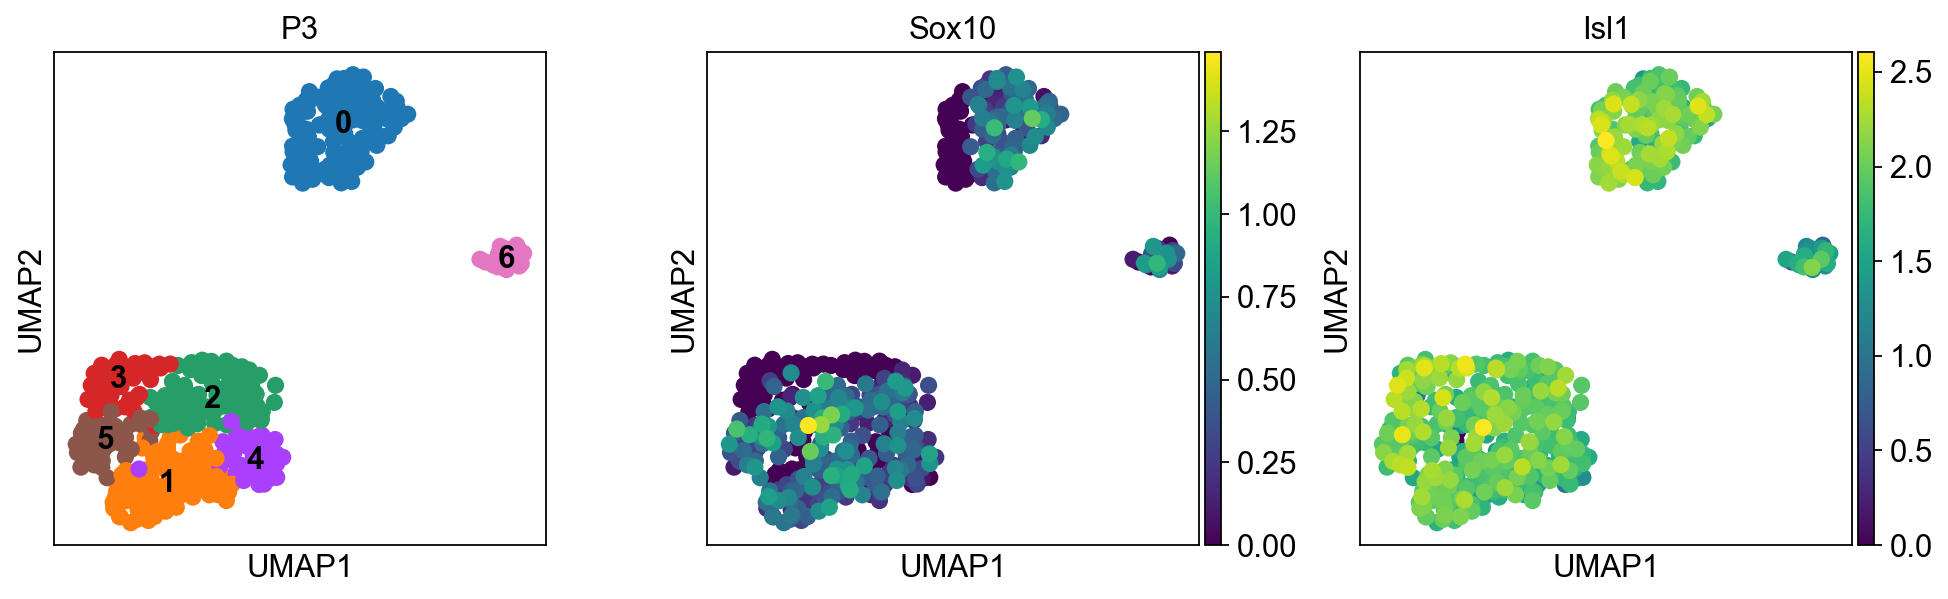

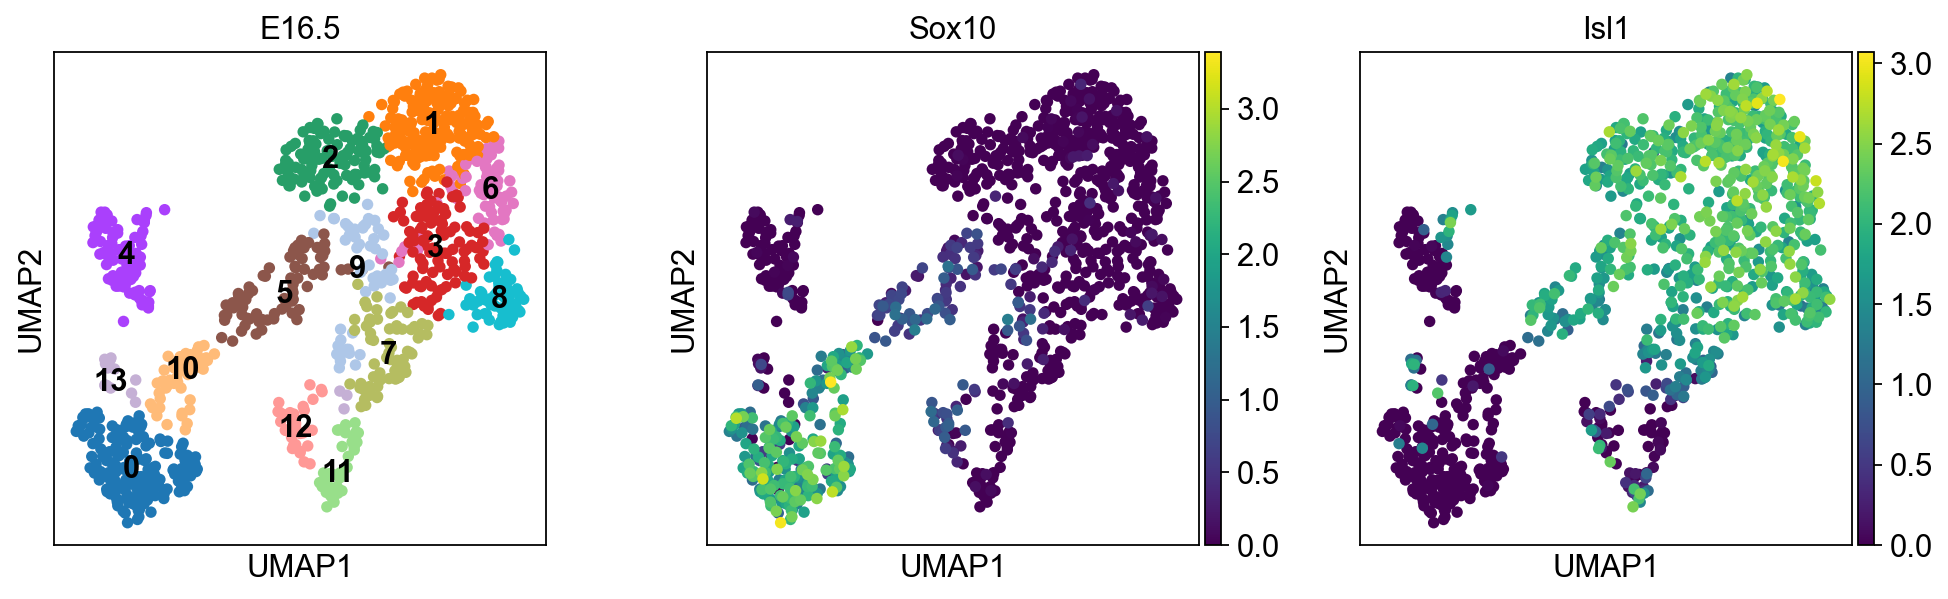

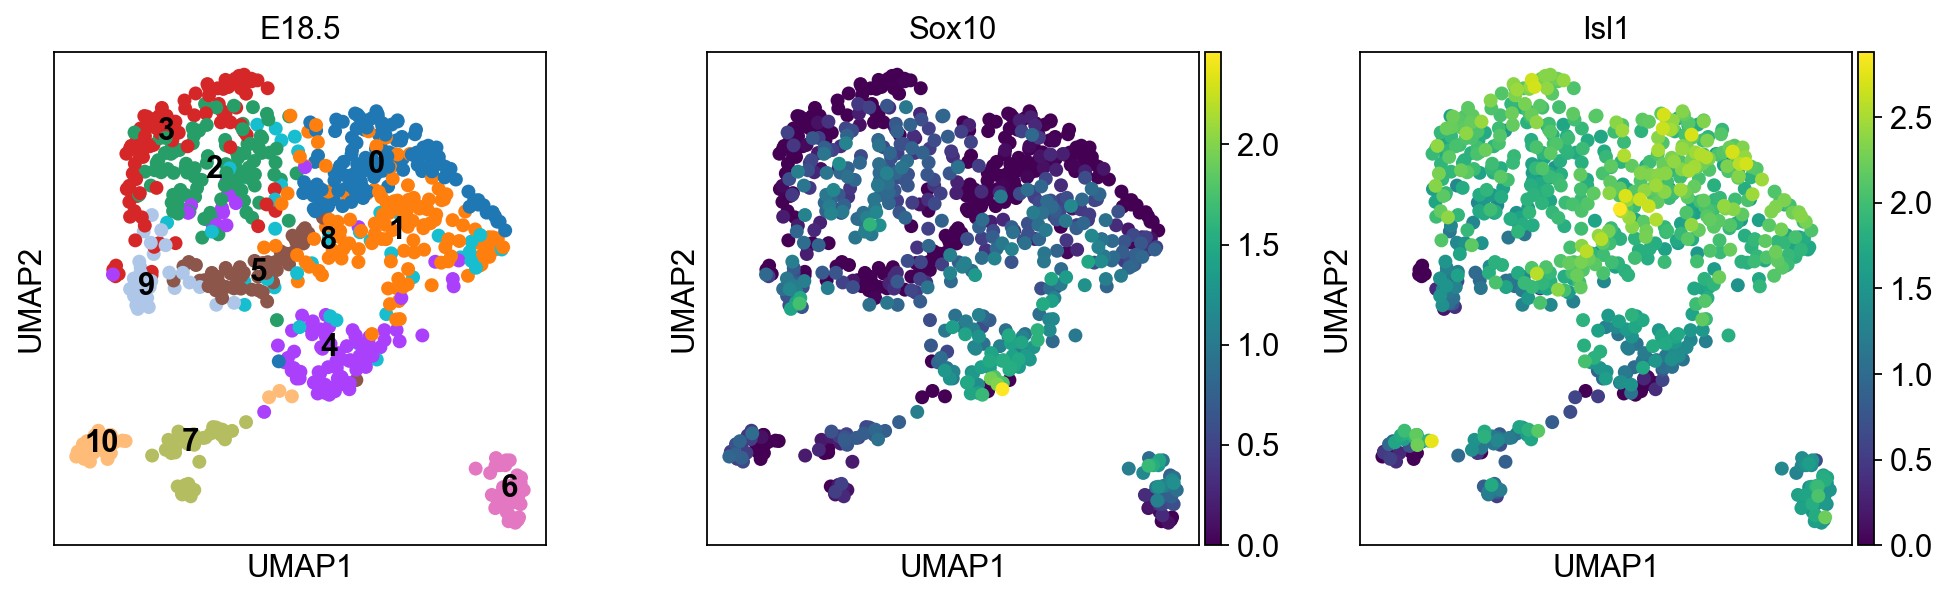

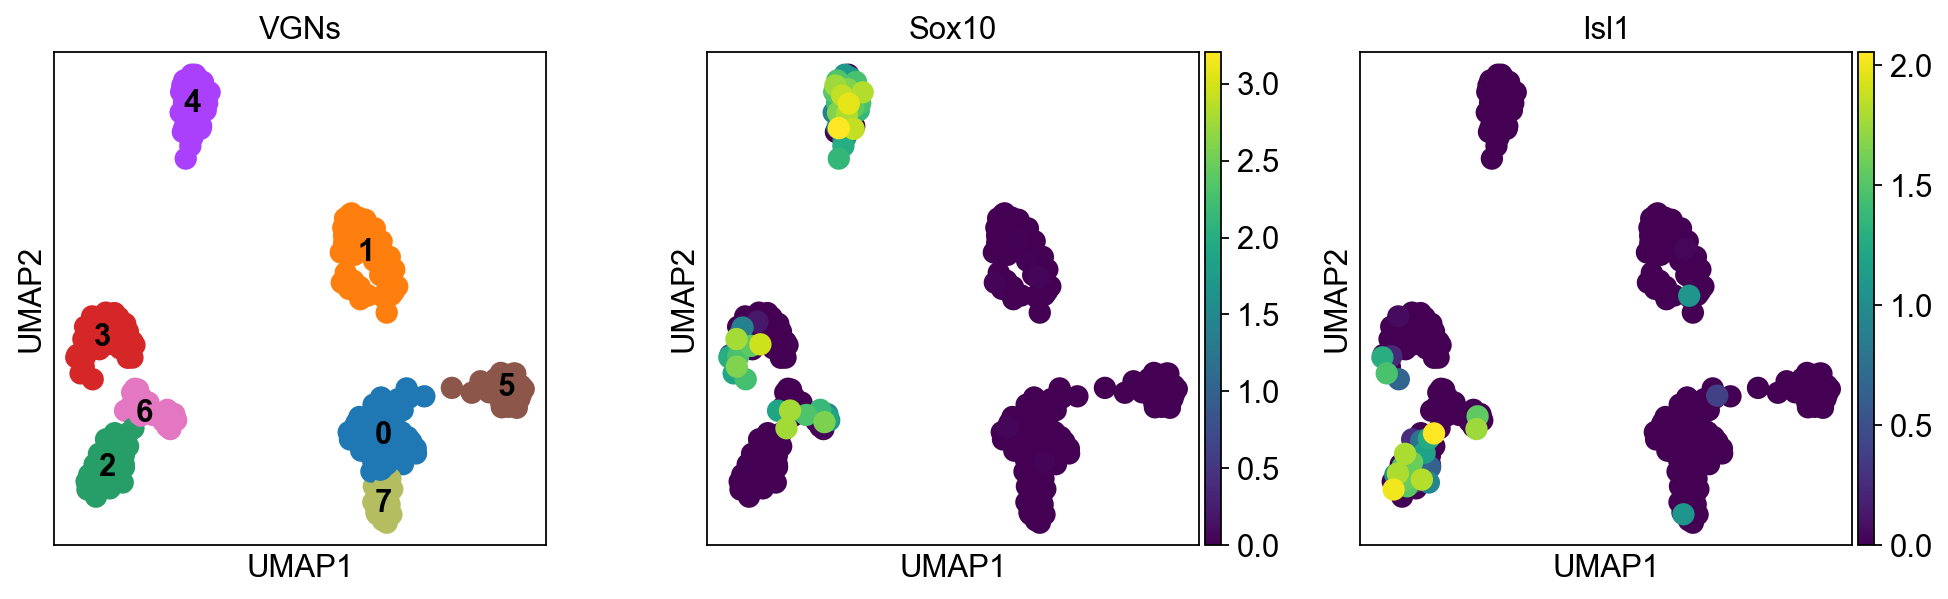

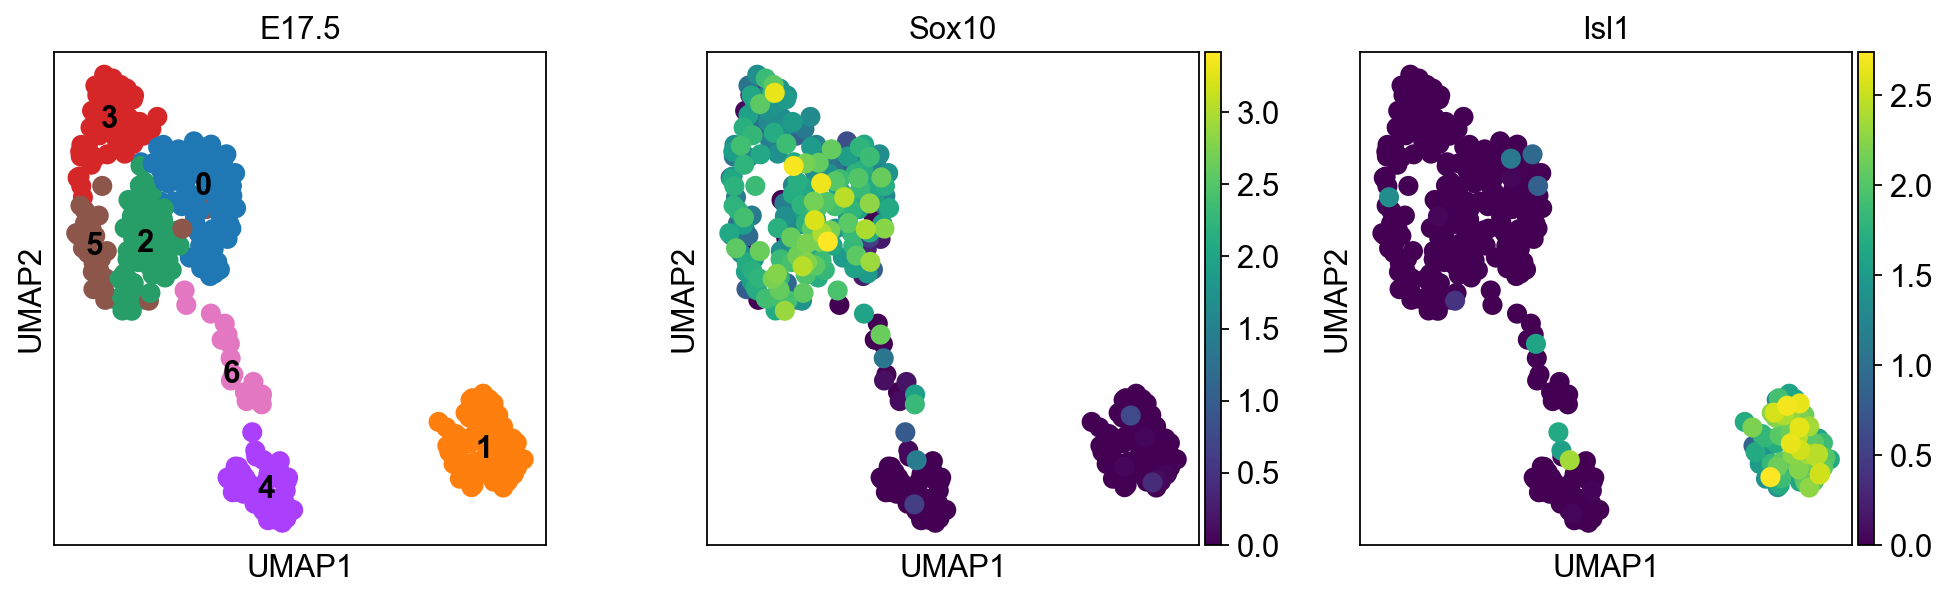

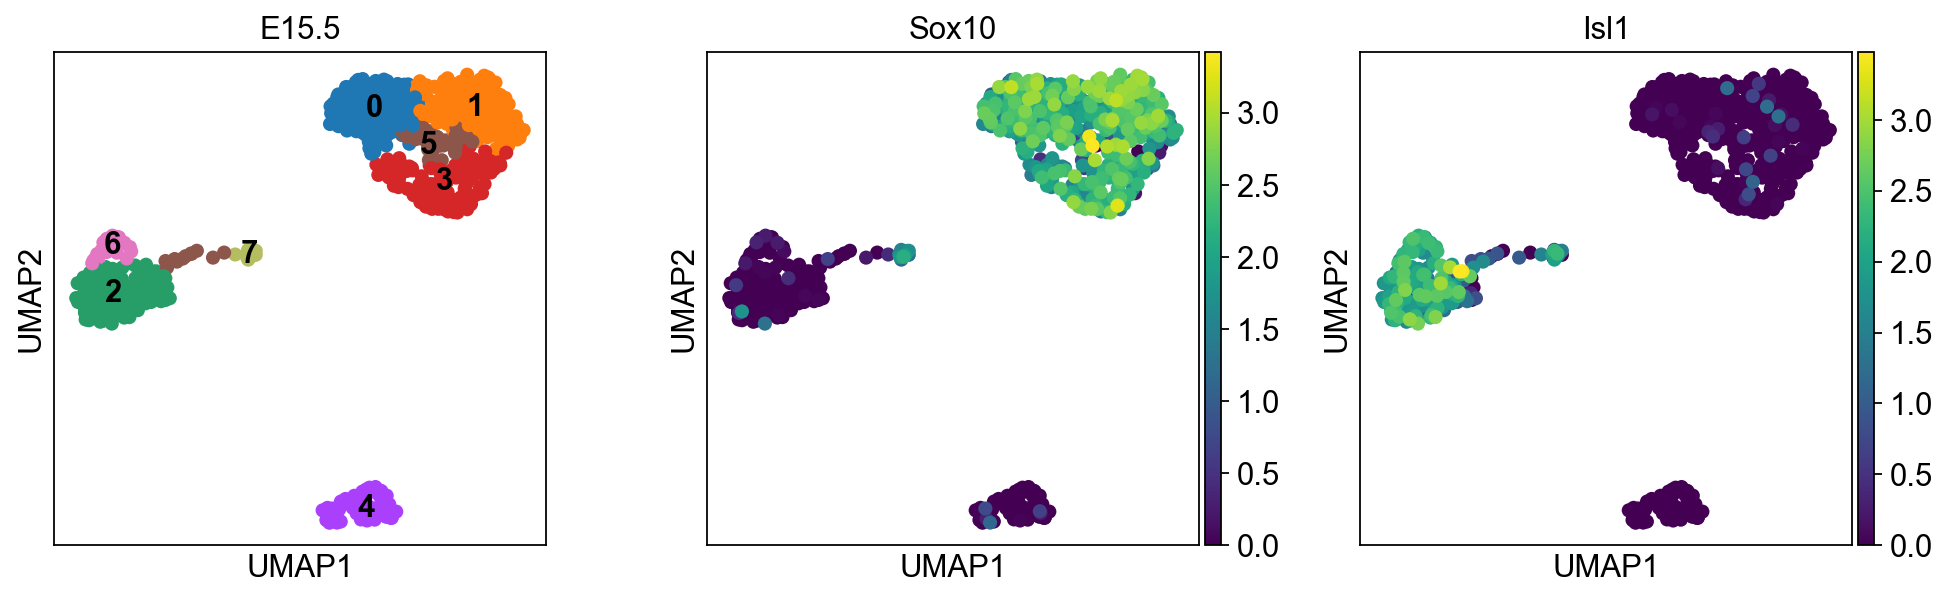

In [30]:
for i in range(len(meta[3].unique())):
    sc.pl.umap(ldatas[i],color=["leiden","Sox10","Isl1"],title=meta[3].unique()[i],legend_loc="on data")

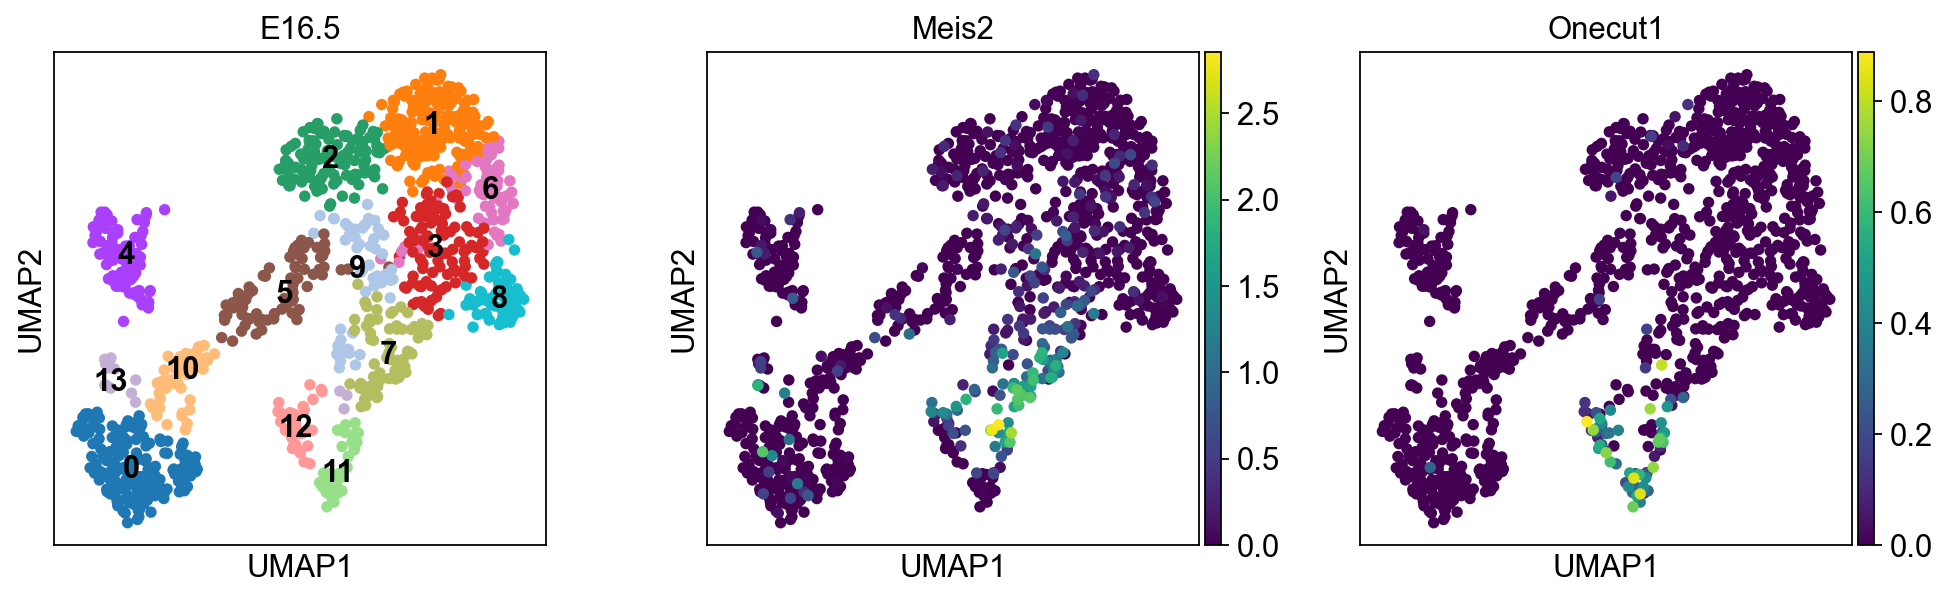

In [31]:
sc.pl.umap(ldatas[2],color=["leiden","Meis2","Onecut1"],title=meta[3].unique()[2],legend_loc="on data")

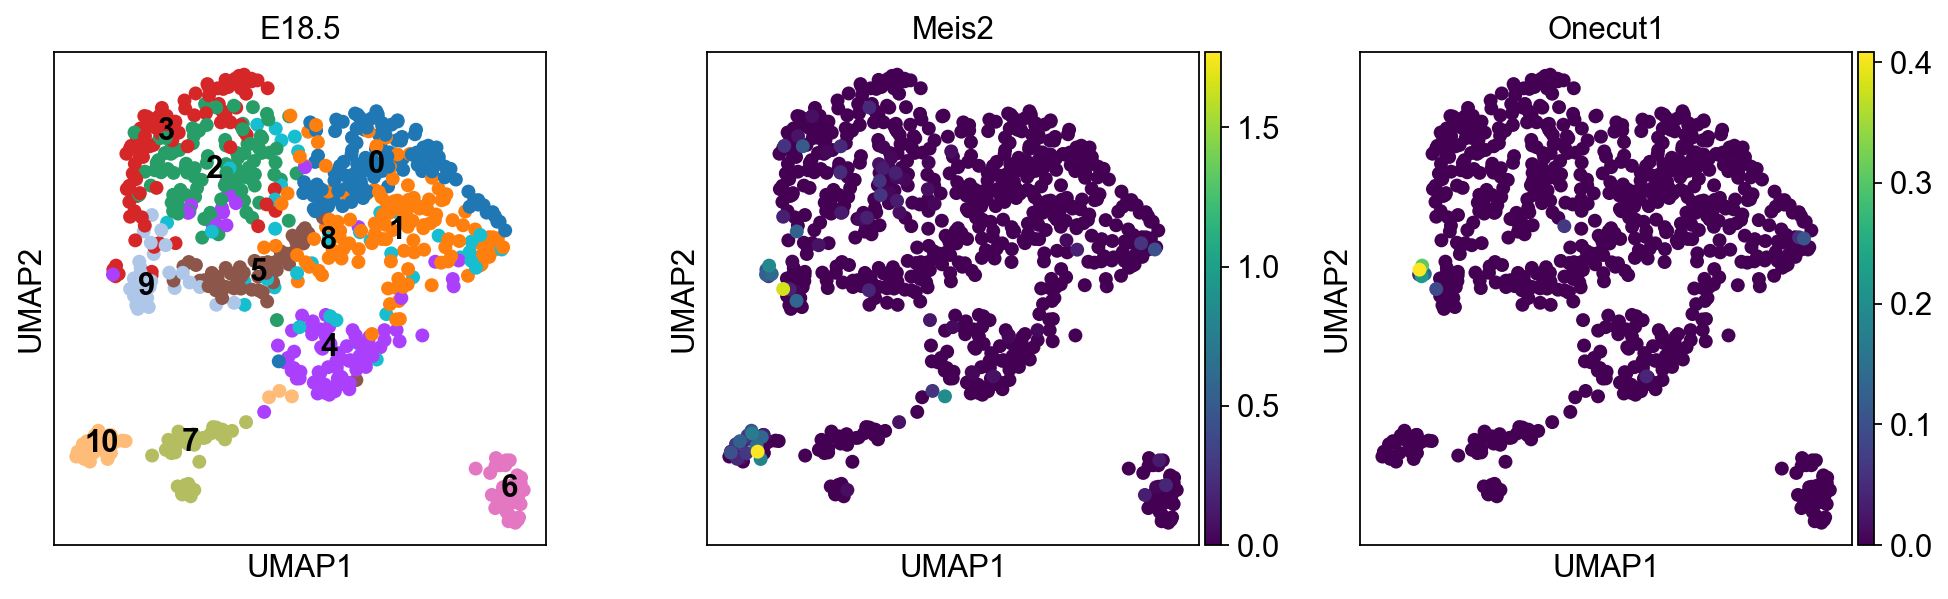

In [32]:
sc.pl.umap(ldatas[3],color=["leiden","Meis2","Onecut1"],title=meta[3].unique()[3],legend_loc="on data")

In [33]:
c_14=ldatas[0].obs_names[ldatas[0].obs.leiden.isin(["4","5","9","12"])]
c_p3=ldatas[1].obs_names
#c_16=ldatas[2].obs_names[ldatas[2].obs.leiden.isin(["1","2","4","5","7","8","10","11"])]
c_16=ldatas[2].obs_names[ldatas[2].obs.leiden.isin(["1","2","3","6","4","8","13","9"])]
c_18=ldatas[3].obs_names[~ldatas[3].obs.leiden2.isin(["4"])]
c_17=ldatas[5].obs_names[ldatas[5].obs.leiden=="1"]
c_15=ldatas[6].obs_names[ldatas[6].obs.leiden.isin(["2","6","4"])]

In [34]:
import numpy as np
tokeep=np.concatenate([c_14,c_p3,c_16,c_18,c_17,c_15])

In [35]:
adata=adata[tokeep]
adata=adata[:,~adata.var_names.isin(glial_code)]

In [37]:
adata.write("data/adata_cleaned_0.3.h5ad")